In [1]:
using StaticArrays, DifferentialEquations, DynamicalSystems
E = 0..30; x = 0..1; y = 0..1
box = E × x × y
using CairoMakie

In [2]:
@inbounds U(y, p) = p[8] + p[9] / ( 1.0 + exp( -50.0 * (y - p[7]) ) )
@inbounds σ(x, p) = 1.0 / ( 1.0 + exp( -20.0 * (x-p[6]) ) )
@inbounds g(E, x, y, p, U_) = log( 1.0 + exp( (p[5] * U_ * x * E + p[11]  ) / (p[1]) ) )

@inbounds function TM(u, p, t)
    
    U_ = U(u[3], p)
    
    du1 = (-u[1] + p[1] * g(u[1], u[2], u[3], p, U_) ) / p[2]
    du2 = (1.0 - u[2]) / p[3] - U_*u[2]*u[1]
    du3 = (-u[3])/p[4] + p[10] * σ(u[2], p)
    
    return SVector(du1, du2, du3)
end
@inbounds function jacob_TM_(u, p, t)
    
    U(y, p, exp50) = p[8] + p[9] / ( 1.0 + exp50 )
    U_y(y, p, exp50) = (50.0 * p[9] * exp50) / (1.0 + exp50)^2
    g(E, x, y, p, U_) = exp((p[5]  * U_ * x * E + p[11]) / p[1])
    σ_der(x, p) = exp( (-20.0) * (x - p[6]) )
    exp50 = exp(-50.0 * (u[3] - p[7]))
    
    U_ = U(u[3], p, exp50)
    Uy = U_y(u[3], p, exp50)
    g_ = g(u[1], u[2], u[3], p, U_)
    σ_deri = σ_der(u[2], p)
    
    g_plus = 1.0 + g_
    g_mult = g_ * U_
    g_plus_mult = p[2] * (g_plus)
    u1p5 = p[5] * u[1]
    Uyu2 = Uy * u[2]
    
    E_E = (-1.0 + ((J * u[2] * g_mult)) / (g_plus) ) / p[2]
    E_x = (u1p5 * g_mult) / (g_plus_mult)
    E_y = (u1p5 * Uyu2 * g_) / (g_plus_mult)
    
    x_E = -U_ * u[2]
    x_x = -1.0 / p[3] - U_ * u[1]
    x_y = -Uyu2 * u[1]
    
    y_x = 20.0 * p[10] * σ_deri / (1.0 + σ_deri)^2
    y_y = -1.0/p[4]
    
    SMatrix{3,3}(E_E, x_E, 0.0,
        E_x, x_x, y_x,
        E_y, x_y, y_y)
end;

In [16]:
const τ = 0.013;  const τD = 0.080;  const τy = 3.3;  const J = 3.07;  const β = 0.300
const xthr = 0.75; const ythr = 0.4
const α = 1.58;  U0 = 0.3;  const ΔU0 = 0.305; I0 = -1.48;

In [17]:
u0 = [8.39353, 0.73803, 0.429055]

3-element Vector{Float64}:
 8.39353
 0.73803
 0.429055

In [18]:
t = 400; tt = 250; tstep = 0.001
time_attract = 100.0

trange = range(0.0, t, step = tstep)
integ_set = (alg = RK4(), adaptive = false, dt = tstep);

In [19]:
I0range = range(-1.48, -1.51, length = 50)

-1.48:-0.0006122448979591836:-1.51

In [20]:
p = [α, τ, τD, τy, J, xthr, ythr, U0, ΔU0, β, I0]
ds = CoupledODEs(TM, u0, p, diffeq = integ_set)

3-dimensional CoupledODEs
 deterministic: true
 discrete time: false
 in-place:      false
 dynamic rule:  TM
 ODE solver:    RK4
 ODE kwargs:    (adaptive = false, dt = 0.001)
 parameters:    [1.58, 0.013, 0.08, 3.3, 3.07, 0.75, 0.4, 0.3, 0.305, 0.3, -1.48]
 time:          0.0
 state:         [8.39353, 0.73803, 0.429055]


In [21]:
fp, eigs, _ = fixedpoints(ds, box, jacob_TM_)

(3-dimensional StateSpaceSet{Float64} with 1 points, Vector{ComplexF64}[[-8.898188740733607 + 0.0im, 2.108515370836325 - 15.909942926974539im, 2.108515370836325 + 15.909942926974539im]], Bool[0])

In [22]:
eigss = zeros(ComplexF64, 50, 3);

In [23]:
for (index, I0) in enumerate(I0range)
    
    p = [α, τ, τD, τy, J, xthr, ythr, U0, ΔU0, β, I0]
    ds = CoupledODEs(TM, u0, p, diffeq = integ_set)
    _, eigs, _ = fixedpoints(ds, box, jacob_TM_)
    eigss[index, :] = eigs[1]
    
end

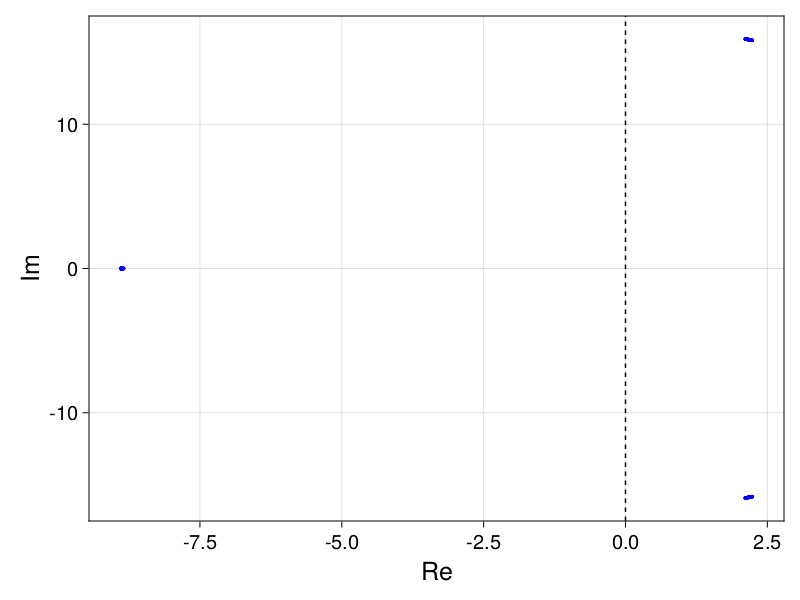

In [24]:
f = Figure()
ax = Axis(f[1, 1], xlabel = "Re", ylabel = "Im", xlabelsize = 25, ylabelsize = 25, xticklabelsize = 20, yticklabelsize = 20)

for (index, _) in enumerate(I0range)
    scatter!(real(eigss[index, 1]), imag(eigss[index, 1]), color = :blue, markersize = 5)
    scatter!(real(eigss[index, 2]), imag(eigss[index, 2]), color = :blue, markersize = 5)
    scatter!(real(eigss[index, 3]), imag(eigss[index, 3]), color = :blue, markersize = 5)
end
vlines!(0.0, color = :black, linestyle = :dash)
f